In [1]:
from utils import *

import time
import numpy as np

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")
context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(1719)

In [2]:
def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')


In [3]:
import datetime
import pandas_datareader.data as web
import bert
import pandas as pd
from loadstocks import loadStocksByTickers
from loadstocks import loadAuNotNaTickersFromYahooExcel
months=72
end = datetime.date.today()
day=end.day
year=end.year-months//12-1
month=months%12+1
start=datetime.datetime(year,month,day)
ticker='GOLD.AX'
y =web.DataReader(ticker,"yahoo",start,end)['Adj Close']   

In [4]:
dataset_ex_df=pd.DataFrame()
dataset_ex_df[ticker]=y
dataset_ex_df[[ticker]].head(3)

,GOLD.AX
Date,
2012-01-19,123.010002
2012-01-22,124.639000
2012-01-23,123.809998


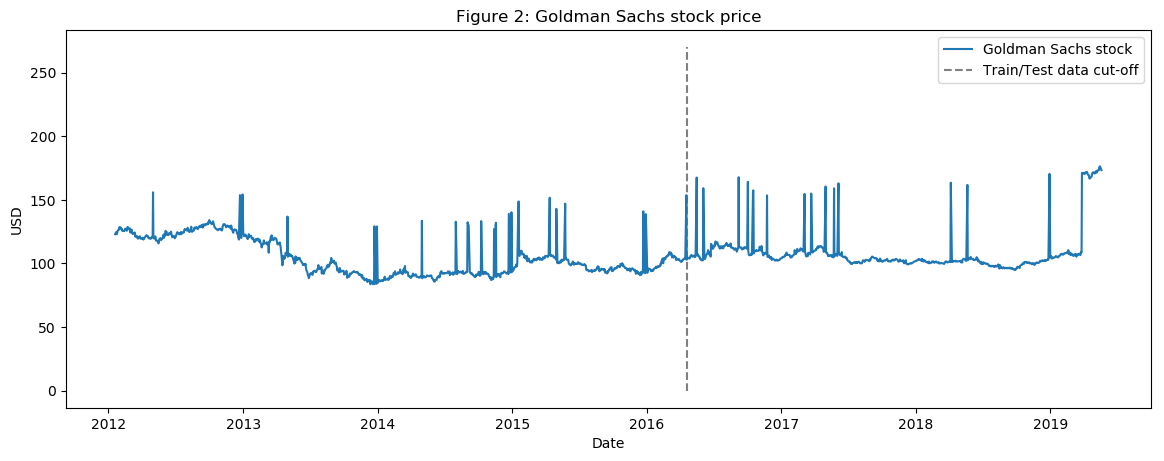

In [5]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(dataset_ex_df.index, dataset_ex_df[ticker], label='Goldman Sachs stock')
plt.vlines(datetime.date(2016,4, 20), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: Goldman Sachs stock price')
plt.legend()
plt.show()

In [6]:
num_training_days = int(dataset_ex_df.shape[0]*.7)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, \
                                                                    dataset_ex_df.shape[0]-num_training_days))

Number of training days: 1297. Number of test days: 556.


In [7]:
def get_technical_indicators(dataset,ticker):
    dataset['ma7'] = dataset[ticker].rolling(window=7).mean()
    dataset['ma21'] = dataset[ticker].rolling(window=21).mean()
    dataset['26ema']=dataset[ticker].ewm(span=26).mean()
    dataset['12ema']=dataset[ticker].ewm(span=12).mean()

    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    dataset['20sd'] = dataset[ticker].rolling(window=20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)

    # Create Exponential moving average
    dataset['ema'] = dataset[ticker].ewm(com=0.5).mean()

    # Create Momentum
    dataset['momentum'] = dataset[ticker]-1
    
    return dataset

In [8]:
dataset_Ti_df=get_technical_indicators(dataset_ex_df,ticker)
dataset_Ti_df

,GOLD.AX,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
Date,,,,,,,,,,,
2012-01-19,123.010002,NaN,NaN,123.010002,123.010002,0.000000,NaN,NaN,NaN,123.010002,122.010002
2012-01-22,124.639000,NaN,NaN,123.855828,123.892376,0.036548,NaN,NaN,NaN,124.231750,123.639000
2012-01-23,123.809998,NaN,NaN,123.839362,123.860224,0.020862,NaN,NaN,NaN,123.939768,122.809998
2012-01-24,123.011002,NaN,NaN,123.607788,123.592157,-0.015631,NaN,NaN,NaN,123.312851,122.011002
2012-01-26,125.994003,NaN,NaN,124.161161,124.244730,0.083569,NaN,NaN,NaN,125.107672,124.994003
2012-01-29,126.428001,NaN,NaN,124.615191,124.775380,0.160189,NaN,NaN,NaN,125.989101,125.428001
2012-01-30,128.384995,125.039571,NaN,125.285631,125.580853,0.295222,NaN,NaN,NaN,127.587094,127.384995
2012-01-31,127.495003,125.680286,NaN,125.641616,125.980306,0.338691,NaN,NaN,NaN,127.525690,126.495003
2012-02-01,127.471001,126.084857,NaN,125.912771,126.275219,0.362448,NaN,NaN,NaN,127.489229,126.471001


In [9]:
dataset_TI_df=dataset_Ti_df['2012-02-13	':]
dataset_TI_df

,GOLD.AX,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
Date,,,,,,,,,,,
2012-02-13,125.507004,126.099714,NaN,126.125754,126.124919,-0.000834,NaN,NaN,NaN,125.532659,124.507004
2012-02-14,126.061996,125.899571,NaN,126.119455,126.114735,-0.004719,NaN,NaN,NaN,125.885551,125.061996
2012-02-15,127.084999,126.013142,NaN,126.212547,126.270524,0.057977,NaN,NaN,NaN,126.685183,126.084999
2012-02-16,127.441002,126.107143,NaN,126.328400,126.457206,0.128806,1.593389,NaN,NaN,127.189062,126.441002
2012-02-19,126.318001,126.212429,126.116238,126.327438,126.435128,0.107690,1.417011,128.950260,123.282216,126.608355,125.318001
2012-02-20,125.739998,126.240714,126.246238,126.274116,126.325404,0.051288,1.370885,128.988008,123.504467,126.029450,124.739998
2012-02-21,127.663002,126.545143,126.390238,126.398116,126.535698,0.137583,1.265277,128.920792,123.859683,127.118485,126.663002
2012-02-22,128.738998,127.006857,126.624952,126.603979,126.880932,0.276954,1.061196,128.747343,124.502561,128.198827,127.738998
2012-02-23,128.070999,127.293857,126.865904,126.731228,127.066875,0.335647,1.079065,129.024034,124.707775,128.113608,127.070999


In [10]:
def plot_technical_indicators(dataset, last_days,ticker):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset[ticker],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()



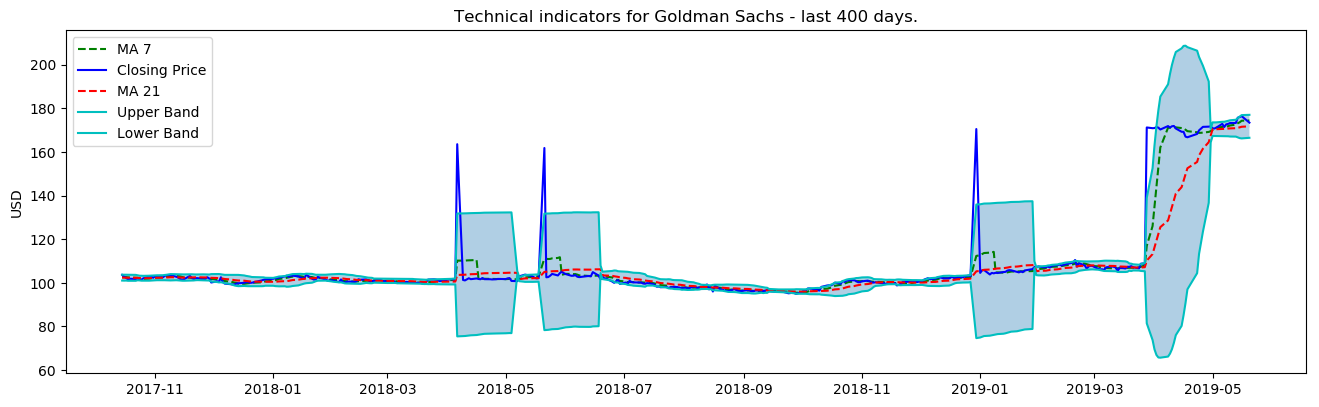

In [11]:
plot_technical_indicators(dataset_TI_df, 400,ticker)

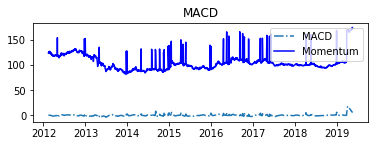

In [12]:
dataset,last_days,ticker=dataset_TI_df, 400,ticker
shape_0 = dataset.shape[0]
xmacd_ = shape_0-last_days
# Plot second subplot
plt.subplot(2, 1, 2)
plt.title('MACD')
plt.plot(dataset['MACD'],label='MACD', linestyle='-.')

plt.plot(dataset['momentum'],label='Momentum', color='b',linestyle='-')

plt.legend()
plt.show()

In [13]:
import bert
data_FT = dataset_ex_df[[ticker]]
close_fft = np.fft.fft(np.asarray(data_FT[ticker].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

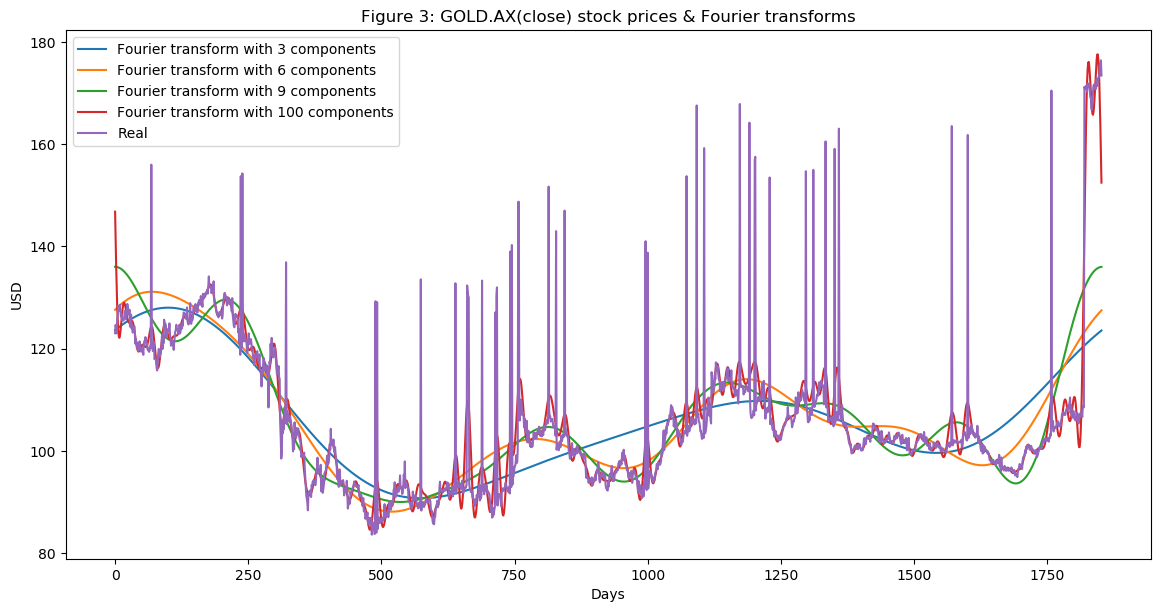

In [14]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT[ticker].values,  label='Real')


plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: '+ticker+'(close) stock prices & Fourier transforms')
plt.legend()
plt.show()

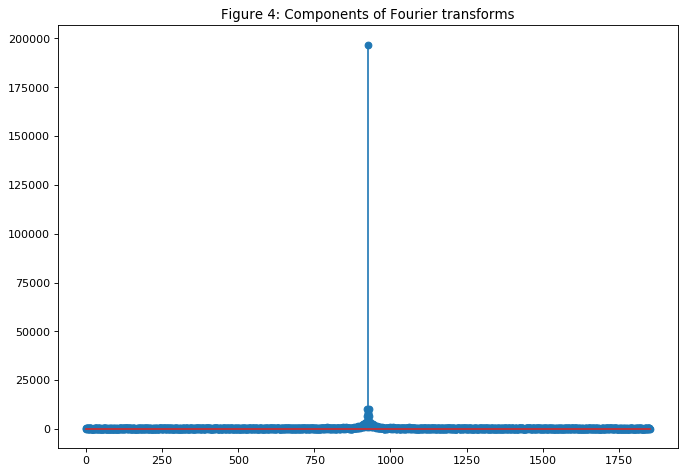

In [15]:
from collections import deque
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Figure 4: Components of Fourier transforms')
plt.show()

In [16]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = data_FT[ticker]
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:              D.GOLD.AX   No. Observations:                 1852
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -6425.040
Method:                       css-mle   S.D. of innovations              7.769
Date:                Mon, 20 May 2019   AIC                          12864.080
Time:                        16:17:51   BIC                          12902.748
Sample:                             1   HQIC                         12878.333
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0276      0.065      0.425      0.671      -0.099       0.155
ar.L1.D.GOLD.AX    -0.6853      0.023    -29.661      0.000      -0.731      -0.640
ar.L2.D.GOLD.AX    -0.5049      

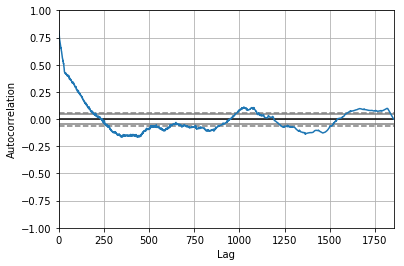

<Figure size 800x560 with 0 Axes>

In [17]:
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show() 

In [18]:
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 64.394


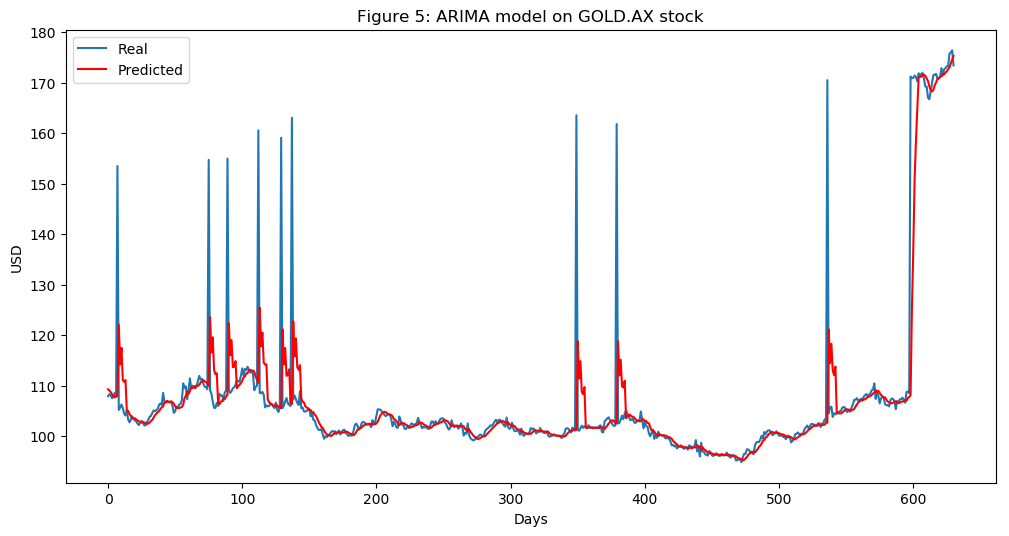

In [19]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on '+ticker+' stock')
plt.legend()
plt.show()

In [20]:
print('Total dataset has {} samples, and {} features.'.format(dataset_TI_df.shape[0], \
                                                              dataset_TI_df.shape[1]))

clean_df = dataset_TI_df.copy()

for f in clean_df.columns:
    if clean_df[f].dtype == 'object':
        label = preprocessing.LabelEncoder()
        label.fit(list(clean_df[f].values))
        clean_df[f] = label.transform(list(clean_df[f].values))
pd.isna(clean_df).sum()

Total dataset has 1837 samples, and 11 features.


GOLD.AX       0
ma7           0
ma21          4
26ema         0
12ema         0
MACD          0
20sd          3
upper_band    4
lower_band    4
ema           0
momentum      0
dtype: int64

In [21]:
def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data[ticker]
    X = data.iloc[:, 1:]
    
    train_samples = int(X.shape[0] * 0.65)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]

    return (X_train, y_train), (X_test, y_test)

In [22]:
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(clean_df)


In [23]:
import xgboost as xgb
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)


In [24]:
xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)
eval_result = regressor.evals_result()
training_rounds = range(len(eval_result['validation_0']['rmse']))


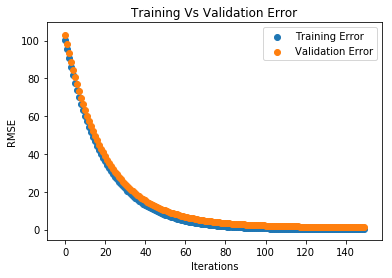

In [25]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

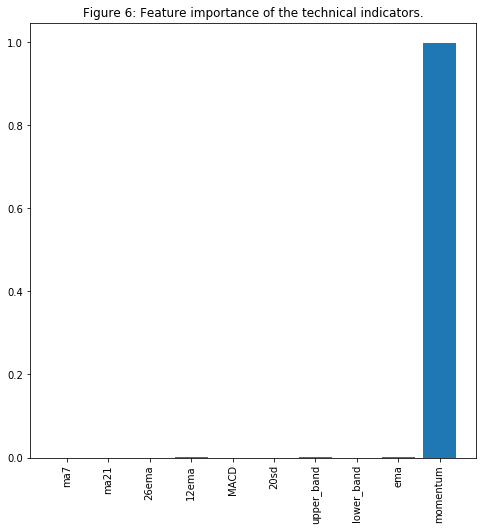

In [26]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()

In [27]:

def gelu(x):
    return 0.5 * x * (1 + math.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * math.pow(x, 3))))
def relu(x):
    return max(x, 0)
def lrelu(x):
    return max(0.01*x, x)

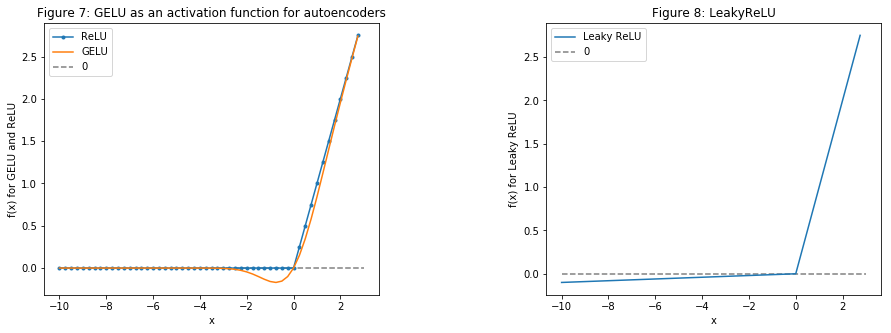

In [28]:
plt.figure(figsize=(15, 5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.5, hspace=None)

ranges_ = (-10, 3, .25)

plt.subplot(1, 2, 1)
plt.plot([i for i in np.arange(*ranges_)], [relu(i) for i in np.arange(*ranges_)], label='ReLU', marker='.')
plt.plot([i for i in np.arange(*ranges_)], [gelu(i) for i in np.arange(*ranges_)], label='GELU')
plt.hlines(0, -10, 3, colors='gray', linestyles='--', label='0')
plt.title('Figure 7: GELU as an activation function for autoencoders')
plt.ylabel('f(x) for GELU and ReLU')
plt.xlabel('x')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot([i for i in np.arange(*ranges_)], [lrelu(i) for i in np.arange(*ranges_)], label='Leaky ReLU')
plt.hlines(0, -10, 3, colors='gray', linestyles='--', label='0')
plt.ylabel('f(x) for Leaky ReLU')
plt.xlabel('x')
plt.title('Figure 8: LeakyReLU')
plt.legend()

plt.show()

In [29]:
batch_size = 64
VAE_data=clean_df
n_batches = VAE_data.shape[0]/batch_size
VAE_data = VAE_data.values

train_iter = mx.io.NDArrayIter(data={'data': VAE_data[:num_training_days,:-1]}, \
                               label={'label': VAE_data[:num_training_days, -1]}, batch_size = batch_size)
test_iter = mx.io.NDArrayIter(data={'data': VAE_data[num_training_days:,:-1]}, \
                              label={'label': VAE_data[num_training_days:,-1]}, batch_size = batch_size)

In [30]:
model_ctx =  mx.cpu()
class VAE(gluon.HybridBlock):
    def __init__(self, n_hidden=400, n_latent=2, n_layers=1, n_output=784, batch_size=100, act_type='relu', **kwargs):
        self.soft_zero = 1e-10
        self.n_latent = n_latent
        self.batch_size = batch_size
        self.output = None
        self.mu = None
        super(VAE, self).__init__(**kwargs)
        
        with self.name_scope():
            self.encoder = nn.HybridSequential(prefix='encoder')
            
            for i in range(n_layers):
                self.encoder.add(nn.Dense(n_hidden, activation=act_type))
            self.encoder.add(nn.Dense(n_latent*2, activation=None))

            self.decoder = nn.HybridSequential(prefix='decoder')
            for i in range(n_layers):
                self.decoder.add(nn.Dense(n_hidden, activation=act_type))
            self.decoder.add(nn.Dense(n_output, activation='sigmoid'))

    def hybrid_forward(self, F, x):
        h = self.encoder(x)
        #print(h)
        mu_lv = F.split(h, axis=1, num_outputs=2)
        mu = mu_lv[0]
        lv = mu_lv[1]
        self.mu = mu

        eps = F.random_normal(loc=0, scale=1, shape=(self.batch_size, self.n_latent), ctx=model_ctx)
        z = mu + F.exp(0.5*lv)*eps
        y = self.decoder(z)
        self.output = y

        KL = 0.5*F.sum(1+lv-mu*mu-F.exp(lv),axis=1)
        logloss = F.sum(x*F.log(y+self.soft_zero)+ (1-x)*F.log(1-y+self.soft_zero), axis=1)
        loss = -logloss-KL

        return loss

In [31]:
net = nn.Sequential()
net.initialize()

In [32]:
n_hidden=400 # neurons in each layer
n_latent=2 
n_layers=3 # num of dense layers in encoder and decoder respectively
n_output=VAE_data.shape[1]-1 

net = VAE(n_hidden=n_hidden, n_latent=n_latent, n_layers=n_layers, n_output=n_output, batch_size=batch_size, act_type='relu')
print(net)

VAE(
  (encoder): HybridSequential(
    (0): Dense(None -> 400, Activation(relu))
    (1): Dense(None -> 400, Activation(relu))
    (2): Dense(None -> 400, Activation(relu))
    (3): Dense(None -> 4, linear)
  )
  (decoder): HybridSequential(
    (0): Dense(None -> 400, Activation(relu))
    (1): Dense(None -> 400, Activation(relu))
    (2): Dense(None -> 400, Activation(relu))
    (3): Dense(None -> 10, Activation(sigmoid))
  )
)


In [33]:
net.collect_params().initialize(mx.init.Xavier(), ctx=mx.cpu())

net.hybridize()
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': .01})

In [34]:
n_epoch = 150
print_period = n_epoch // 10
start = time.time()

training_loss = []
validation_loss = []
for epoch in range(n_epoch):
    epoch_loss = 0
    epoch_val_loss = 0

    train_iter.reset()
    test_iter.reset()

    n_batch_train = 0
    for batch in train_iter:
        n_batch_train +=1
        data = batch.data[0].as_in_context(mx.cpu())

        with autograd.record():
            loss = net(data)
        loss.backward()
        trainer.step(data.shape[0])
        epoch_loss += nd.mean(loss).asscalar()

    n_batch_val = 0
    for batch in test_iter:
        n_batch_val +=1
        data = batch.data[0].as_in_context(mx.cpu())
        loss = net(data)
        epoch_val_loss += nd.mean(loss).asscalar()

    epoch_loss /= n_batch_train
    epoch_val_loss /= n_batch_val

    
    training_loss.append(epoch_loss)
    validation_loss.append(epoch_val_loss)

    """if epoch % max(print_period, 1) == 0:
        print('Epoch {}, Training loss {:.2f}, Validation loss {:.2f}'.\
              format(epoch, epoch_loss, epoch_val_loss))"""

end = time.time()
print('Training completed in {} seconds.'.format(int(end-start)))

Training completed in 28 seconds.


In [35]:
dataset_total_df=pd.DataFrame(dataset_ex_df.index)

vae_added_df = mx.nd.array(dataset_total_df.iloc[:, :-1].values)
print('The shape of the newly created (from the autoencoder) features is {}.'.format(vae_added_df.shape))

The shape of the newly created (from the autoencoder) features is (1853, 0).


In [36]:
pca = PCA(n_components=.8)
x_pca = StandardScaler().fit_transform(vae_added_df)
principalComponents = pca.fit_transform(x_pca)

ValueError: Found array with 0 feature(s) (shape=(1853, 0)) while a minimum of 1 is required by StandardScaler.

In [ ]:
gan_num_features = dataset_total_df.shape[1]
sequence_length = 17

class RNNModel(gluon.Block):
    def __init__(self, num_embed, num_hidden, num_layers, bidirectional=False, \
                 sequence_length=sequence_length, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.num_hidden = num_hidden
        with self.name_scope():
            self.rnn = rnn.LSTM(num_hidden, num_layers, input_size=num_embed, \
                                bidirectional=bidirectional, layout='TNC')
            
            self.decoder = nn.Dense(1, in_units=num_hidden)
    
    def forward(self, inputs, hidden):
        output, hidden = self.rnn(inputs, hidden)
        decoded = self.decoder(output.reshape((-1, self.num_hidden)))
        return decoded, hidden
    
    def begin_state(self, *args, **kwargs):
        return self.rnn.begin_state(*args, **kwargs)
    
lstm_model = RNNModel(num_embed=gan_num_features, num_hidden=500, num_layers=1)
lstm_model.collect_params().initialize(mx.init.Xavier(), ctx=mx.cpu())
trainer = gluon.Trainer(lstm_model.collect_params(), 'adam', {'learning_rate': .01})
loss = gluon.loss.L1Loss()

In [ ]:
print(lstm_model)

In [ ]:
class TriangularSchedule():
    def __init__(self, min_lr, max_lr, cycle_length, inc_fraction=0.5):     
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.cycle_length = cycle_length
        self.inc_fraction = inc_fraction
        
    def __call__(self, iteration):
        if iteration <= self.cycle_length*self.inc_fraction:
            unit_cycle = iteration * 1 / (self.cycle_length * self.inc_fraction)
        elif iteration <= self.cycle_length:
            unit_cycle = (self.cycle_length - iteration) * 1 / (self.cycle_length * (1 - self.inc_fraction))
        else:
            unit_cycle = 0
        adjusted_cycle = (unit_cycle * (self.max_lr - self.min_lr)) + self.min_lr
        return adjusted_cycle

class CyclicalSchedule():
    def __init__(self, schedule_class, cycle_length, cycle_length_decay=1, cycle_magnitude_decay=1, **kwargs):
        self.schedule_class = schedule_class
        self.length = cycle_length
        self.length_decay = cycle_length_decay
        self.magnitude_decay = cycle_magnitude_decay
        self.kwargs = kwargs
    
    def __call__(self, iteration):
        cycle_idx = 0
        cycle_length = self.length
        idx = self.length
        while idx <= iteration:
            cycle_length = math.ceil(cycle_length * self.length_decay)
            cycle_idx += 1
            idx += cycle_length
        cycle_offset = iteration - idx + cycle_length
        
        schedule = self.schedule_class(cycle_length=cycle_length, **self.kwargs)
        return schedule(cycle_offset) * self.magnitude_decay**cycle_idx

In [ ]:
schedule = CyclicalSchedule(TriangularSchedule, min_lr=0.5, max_lr=2, cycle_length=500)
iterations=1500

plt.plot([i+1 for i in range(iterations)],[schedule(i) for i in range(iterations)])
plt.title('Learning rate for each epoch')
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.show()

In [ ]:
num_fc = 512

# ... other parts of the GAN

cnn_net = gluon.nn.Sequential()
with net.name_scope():
    
    # Add the 1D Convolutional layers
    cnn_net.add(gluon.nn.Conv1D(32, kernel_size=5, strides=2))
    cnn_net.add(nn.LeakyReLU(0.01))
    cnn_net.add(gluon.nn.Conv1D(64, kernel_size=5, strides=2))
    cnn_net.add(nn.LeakyReLU(0.01))
    cnn_net.add(nn.BatchNorm())
    cnn_net.add(gluon.nn.Conv1D(128, kernel_size=5, strides=2))
    cnn_net.add(nn.LeakyReLU(0.01))
    cnn_net.add(nn.BatchNorm())
    
    # Add the two Fully Connected layers
    cnn_net.add(nn.Dense(220, use_bias=False), nn.BatchNorm(), nn.LeakyReLU(0.01))
    cnn_net.add(nn.Dense(220, use_bias=False), nn.Activation(activation='relu'))
    cnn_net.add(nn.Dense(1))

In [ ]:
print(cnn_net)

In [ ]:
# Initialize the optimizer
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

utility = UtilityFunction(kind="ucb", kappa=2.5, xi=0.0)

In [ ]:
from utils import plot_prediction

In [38]:
dataset_ex_df

,GOLD.AX,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
Date,,,,,,,,,,,
2012-01-19,123.010002,NaN,NaN,123.010002,123.010002,0.000000,NaN,NaN,NaN,123.010002,122.010002
2012-01-22,124.639000,NaN,NaN,123.855828,123.892376,0.036548,NaN,NaN,NaN,124.231750,123.639000
2012-01-23,123.809998,NaN,NaN,123.839362,123.860224,0.020862,NaN,NaN,NaN,123.939768,122.809998
2012-01-24,123.011002,NaN,NaN,123.607788,123.592157,-0.015631,NaN,NaN,NaN,123.312851,122.011002
2012-01-26,125.994003,NaN,NaN,124.161161,124.244730,0.083569,NaN,NaN,NaN,125.107672,124.994003
2012-01-29,126.428001,NaN,NaN,124.615191,124.775380,0.160189,NaN,NaN,NaN,125.989101,125.428001
2012-01-30,128.384995,125.039571,NaN,125.285631,125.580853,0.295222,NaN,NaN,NaN,127.587094,127.384995
2012-01-31,127.495003,125.680286,NaN,125.641616,125.980306,0.338691,NaN,NaN,NaN,127.525690,126.495003
2012-02-01,127.471001,126.084857,NaN,125.912771,126.275219,0.362448,NaN,NaN,NaN,127.489229,126.471001
